# XGBoost

## Import data and libraries

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Group Project/depression.csv')
df

,Code,Age_Numerical,Gender,Marital,Marital_problems,Religion_binary,Religion_help,Med_or_not,Expenses,Monthly_expenses,...,DASS_stress_numerical,MSPSS_family,MSPSS_friends,MSPSS_significant_others,DASS_depression_binary,DASS_depression_severity,DASS_anxiety_binary,DASS_anxiety_severity,DASS_stress_binary,DASS_stress_severity
0,1,34,0,0,0,1,1,1,2,1,...,0,27.2,24.0,26.0,0,0,0,0,0,0
1,2,32,1,0,0,1,1,1,1,0,...,2,28.0,28.0,28.0,0,0,0,0,0,0
2,3,33,0,0,0,1,1,1,1,0,...,0,28.0,28.0,28.0,0,0,0,0,0,0
3,4,33,1,0,1,1,1,1,2,1,...,18,25.2,21.2,24.0,1,2,1,4,1,1
4,5,39,1,0,0,1,1,1,2,1,...,2,26.0,20.0,28.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,312,23,1,1,0,0,1,1,2,1,...,8,25.2,25.2,27.2,0,0,0,0,0,0
312,313,36,0,1,0,0,0,0,2,1,...,0,23.2,20.0,24.0,0,0,0,0,0,0
313,314,33,0,0,0,0,0,1,2,1,...,0,25.2,19.2,27.2,0,0,0,0,0,0
314,315,25,1,1,0,1,0,1,0,0,...,26,14.0,13.2,13.2,1,4,1,2,1,2


## Data preprocessing

### Remove unrelated and inferred features

In [27]:
print(df.columns)
df.drop(columns=['Code','Residence_high_COVID1','Living_with','Monthly_expenses',
                 'DASS_depression_numerical','DASS_anxiety_numerical','DASS_stress_numerical',
                 'DASS_depression_binary','DASS_anxiety_binary','DASS_anxiety_severity','DASS_stress_binary','DASS_stress_severity'
                 ],
        inplace=True, axis=1)
print(df.columns)

Index(['Code', 'Age_Numerical', 'Gender', 'Marital', 'Marital_problems',
       'Religion_binary', 'Religion_help', 'Med_or_not', 'Expenses',
       'Monthly_expenses', 'Living_with1', 'Living_with', 'Worry_family',
       'Routine_loss', 'Class_hours', 'Stress_class_disrupted',
       'Medical_illness', 'Mental_illness', 'COVID_symptoms',
       'Residence_high_COVID1', 'Residence_high_COVID', 'Quarantine',
       'DASS_depression_numerical', 'DASS_anxiety_numerical',
       'DASS_stress_numerical', 'MSPSS_family', 'MSPSS_friends',
       'MSPSS_significant_others', 'DASS_depression_binary',
       'DASS_depression_severity', 'DASS_anxiety_binary',
       'DASS_anxiety_severity', 'DASS_stress_binary', 'DASS_stress_severity'],
      dtype='object')
Index(['Age_Numerical', 'Gender', 'Marital', 'Marital_problems',
       'Religion_binary', 'Religion_help', 'Med_or_not', 'Expenses',
       'Living_with1', 'Worry_family', 'Routine_loss', 'Class_hours',
       'Stress_class_disrupted', 'Med

### Remove invalid data

In [28]:
df = df.drop(index = 168)

### Feature selection

In [29]:
df.drop(columns=['Age_Numerical','Class_hours',
                'Gender','Med_or_not','Religion_binary',
                'Worry_family'],
        inplace=True, axis=1)
print(df.columns)

Index(['Marital', 'Marital_problems', 'Religion_help', 'Expenses',
       'Living_with1', 'Routine_loss', 'Stress_class_disrupted',
       'Medical_illness', 'Mental_illness', 'COVID_symptoms',
       'Residence_high_COVID', 'Quarantine', 'MSPSS_family', 'MSPSS_friends',
       'MSPSS_significant_others', 'DASS_depression_severity'],
      dtype='object')


### Extract input and output features

In [30]:
from collections import Counter
X = df
y = df['DASS_depression_severity']

X = X.drop(columns='DASS_depression_severity')

### Oversampling

In [31]:
print(f"Initial: {Counter(y)}")

Initial: Counter({0: 200, 1: 49, 2: 37, 3: 16, 4: 13})


In [32]:
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(sampling_strategy={0: 200, 1: 150, 2: 120, 3: 50, 4: 50})
X, y = over.fit_resample(X, y)
print(f"Oversampled: {Counter(y)}")

Oversampled: Counter({0: 200, 1: 150, 2: 120, 3: 50, 4: 50})


### One hot encoding for categorical data

In [33]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
X[['Alone','Friends/Coursemates','Family']] = ohe.fit_transform(X['Living_with1'].values.reshape(-1,1))
X[['< RM1000','RM1000 - 3000','> RM3000']] = ohe.fit_transform(X['Expenses'].values.reshape(-1,1))
# y = ohe.fit_transform(y.values.reshape(-1,1))

X = X.drop(columns=['Living_with1','Expenses'])
y

0      0
1      0
2      0
3      2
4      0
      ..
565    4
566    4
567    4
568    4
569    4
Name: DASS_depression_severity, Length: 570, dtype: int64

### Split into the training and test set

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(399, 19) (399,)
(171, 19) (171,)


### Feature normalisation

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def featureNormalisation():
  numeric_data = ['MSPSS_family', 'MSPSS_friends', 'MSPSS_significant_others']

  ct = ColumnTransformer([('scaler', StandardScaler(), numeric_data)], remainder='passthrough')

  X_train_scaled = ct.fit_transform(X_train)
  # print(pd.DataFrame(X_train_scaled, columns = ct.get_feature_names_out()))
  # the test set uses the fitted scaler in train dataset to transform in the test set
  X_test_scaled = ct.transform(X_test)
  return X_train_scaled, X_test_scaled, ct

X_train_scaled, X_test_scaled, ct = featureNormalisation()
features = ct.get_feature_names_out()

## Training model

### Define model

In [36]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(objective='multi:softprob')

### Hyperparameter tuning

In [37]:
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Create the parameter grid based on the results of random search 

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 2000, stop = 3000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 10)],
               'min_samples_split': [1, 3, 5, 7],
               'min_samples_leaf': [1, 2, 4, 6],
               'bootstrap': [True, False]}
# Create a based model
model = xgb.XGBClassifier(solver='lbfgs')
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, n_jobs = -1)

grid_search.fit(X_train_scaled, y_train)
grid_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 2888}

In [39]:
model = grid_search.best_estimator_

### Performance metrics

### Accuracy

In [40]:
model.score(X_test_scaled, y_test)

0.8596491228070176

### Classification report

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_scaled)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81        54
           1       0.83      0.88      0.85        56
           2       0.93      0.95      0.94        39
           3       0.80      0.89      0.84         9
           4       0.80      0.92      0.86        13

    accuracy                           0.86       171
   macro avg       0.85      0.88      0.86       171
weighted avg       0.86      0.86      0.86       171



### Confusion matrix

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[41, 10,  1,  1,  1],
       [ 3, 49,  2,  0,  2],
       [ 2,  0, 37,  0,  0],
       [ 1,  0,  0,  8,  0],
       [ 0,  0,  0,  1, 12]])

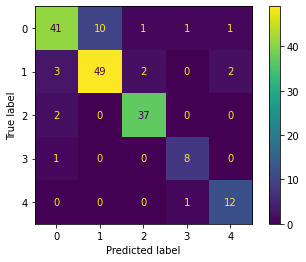

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

### ROC curve

#### Area under the ROC curve

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])
roc_auc_score(y_test, y_pred, multi_class = 'ovo')

0.9202644153410067

#### Plot of ROC curve

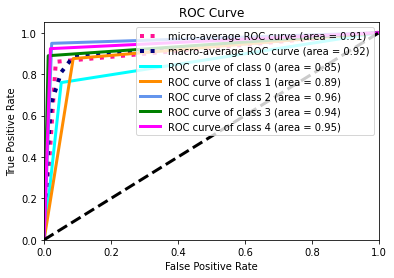

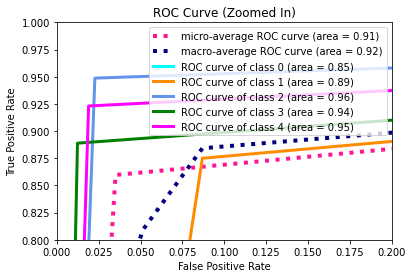

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from numpy import interp
from itertools import cycle

n_classes = 5

# Plot linewidth.
lw = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="upper right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Zoomed In)')
plt.legend(loc="upper right")
plt.show()

## Save model and scaler

In [46]:
import joblib
joblib.dump(model, 'XGB_model.pkl')
joblib.dump(ct, 'XGB_scaler.pkl')

['XGB_scaler.pkl']